# | DCGAN

<a href="https://arxiv.org/abs/1511.06434" style="font-size: 17px"> DCGAN Paper link</a> </br>
<a href="https://pytorch.org/" style="font-size: 17px"> PyTorch</a>
<br />
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*rdXKdyfNjorzP10ZA3yNmQ.png">

In [1]:
#Basic import 
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Torch Imports
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

#Torch-vision Imports
import torchvision.datasets as dataload
import torchvision.transforms as transforms
import torchvision.utils as vutils

#tdqdm visualizser
from tqdm.notebook import tqdm

# | Global variables

In [2]:
dataroot = "/kaggle/input/animefacedataset"

#gpu parameters
ngpu = 2
workers = 2

#image and batch
batch_size = 128
image_size = 64

#number of channels
nc = 3

#latent vector
nz = 100

#generator and discriminator neurons
G = 64
D = 64

#learning rate parameters
lr = 0.0002
beta1 = 0.5

# | Load the Datasets (Train & Validation Split)

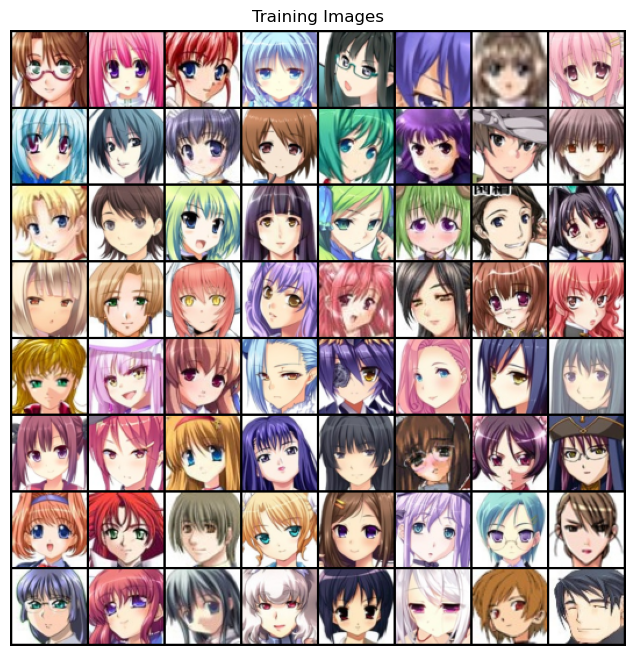

In [3]:
#Load the dataset from the folder | If you are using pytorch dataset, substitue the code accordingly
dataset = dataload.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

#Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

<h1>| Generator and Discriminator</h1>

<p style="font-size: 17px">In GAN, Generators play the role of upsampling and downsampling. The generator takes as input a low-resolution image or a random noise vector and progressively upsamples it. Generators on the other hand downsample the image reducing the dimesnions.</p>
    
<h3>Up Sampling - Generator</h3>
<p style="font-size: 17px">Upsampling allows the generator to transform low-resolution inputs into higher-resolution outputs that resemble real data. Transposed convolutions, Nearest Neighbor Interpolation, Bilinear Interpolation or Pixel Shuffle is often used. in DCGAN, Transposed convolutions is used. </p>
<h4>Note on Transposed CNNs</h4>
<p style="font-size: 17px">Transposed convolutions can effectively increase resolution while preserving certain structural patterns. They expand the spatial dimensions of feature maps.These reverse this process of regular CNNs by expanding the spatial dimensions of an input tensor while learning appropriate weights through backpropagation. Instead of sliding filters over the input and downsampling it, these convolutions use fractional strides greater than 1 to upsample and increase resolution.</p>


<h3>Down Sampling - Discriminator</h3>
<p style="font-size: 17px">Downsampling operation is commonly used in the generator network to gradually decrease the size of the data and capture high-level features. Down Sampling performs the following</p>
<ol style="font-size: 17px">
    <li>Dimensionality Reduction
    <li>By progressively downsampling, GANs can learn hierarchical representations where lower-resolution feature maps capture global context while higher-resolution ones focus on finer details
    <li>Enables GAN to learn more robust and generalized features by not focusing individual pixels
</ol>

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim

        def block(in_channels, out_channels, normalize=True, ks=4, s=2, pad=1):
            layers = []
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=ks, stride=s, padding=pad, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, G * 8, normalize=False, s=1, pad=0),
            *block(G * 8, G * 4),
            *block(G * 4, G * 2),
            *block(G * 2, G),
            nn.ConvTranspose2d(in_channels=G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)
    
netG = Generator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

DataParallel(
  (module): Generator(
    (model): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): Tanh()
    )
  )
)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_channels, out_channels, normalize=True):
            layers=[]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(3, D, normalize=False),
            *block(D, D*2),
            *block(D*2, D*4),
            *block(D*4, D*8),
            nn.Conv2d(D*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, img):
        return self.model(img)
    
netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
   

<h1>| Set Optimizers and Loss Functions</h1>

In [7]:
criterion = nn.BCELoss() #Binary Cross Entropy
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<h1>| Train-Validation Pipeline</h1>

<p style="font-size: 17px">The Generator generates the fake image. We train the discriminator with the real images and the fake generated images. Mean of the losses found on both the steps (using BCE Loss function) gives the loss of <b>Discriminator</b>. Similar approch is done for <b>Generator</b> where we enable gradient for generator optimization and send another forwards pass to the discriminator</p>

In [8]:
img_list = []
train={
    "G_losses" : [],
    "D_losses" : [],
    "D_xs" : [],
    "D_G_z1s" : [],
    "D_G_z2s" : []
}

val={
    "G_losses" : [],
    "D_losses" : [],
    "D_xs" : [],
    "D_G_z1s" : [],
    "D_G_z2s" : []
}

iters = 0
num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    
    #TRAINING LOOP
    for i, data in enumerate(train_dataloader, 0):
        optimizerD.zero_grad()
        
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        #GENERATE FAKE IMAGE
        targets = torch.ones(batch_size, 1, device=device)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        #DISCRIMINATOR LOSS CALCULATION
        #REAL LOSS
        output = netD(real_data).view(-1)
        real_targets = torch.ones(real_data.size(0), 1, device=device)
        errD_real = criterion(output, real_targets.squeeze(1))
        errD_real.backward()
        D_x = output.mean().item()

        #FAKE LOSS
        fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, fake_targets.squeeze(1))
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        #DISCRIMINATOR LOSS
        errD = (errD_real + errD_fake)/2

        optimizerD.step()

        #GENERATOR LOSS CALCULATION
        optimizerG.zero_grad()
        output = netD(fake_data).view(-1)
        Gfake_targets = torch.ones_like(output)

        errG = criterion(output, Gfake_targets)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        #SAVE THE LOGS
        train["G_losses"].append(errG.item())
        train["D_losses"].append(errD.item())
        train["D_xs"].append(D_x)
        train["D_G_z1s"].append(D_G_z1)
        train["D_G_z2s"].append(D_G_z2)

    with torch.no_grad():
        #VALIDATION LOOP
        for i, data in enumerate(val_dataloader, 0):
        
            real_data = data[0].to(device)
            b_size = real_data.size(0)

            targets = torch.ones(batch_size, 1, device=device)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)

            output = netD(real_data).view(-1)
            real_targets = torch.ones(real_data.size(0), 1, device=device)
            errD_real = criterion(output, real_targets.squeeze(1))
            D_x = output.mean().item()

            fake_targets = torch.zeros(fake_data.size(0), 1, device=device)
            output = netD(fake_data.detach()).view(-1)
            errD_fake = criterion(output, fake_targets.squeeze(1))
            D_G_z1 = output.mean().item()

            errD = (errD_real + errD_fake)/2

            output = netD(fake_data).view(-1)
            Gfake_targets = torch.ones_like(output)

            errG = criterion(output, Gfake_targets)
            D_G_z2 = output.mean().item()

            val["G_losses"].append(errG.item())
            val["D_losses"].append(errD.item())
            val["D_xs"].append(D_x)
            val["D_G_z1s"].append(D_G_z1)
            val["D_G_z2s"].append(D_G_z2)
        
    
    print('Train Logs - [Epoch %d] : G_Loss : %.4f | D_Loss : %.4f | D(x) : %.4f | D(G(z)): %.4f/%.4f'%(epoch,train["G_losses"][epoch],
                                                                                           train["D_losses"][epoch],
                                                                                           train["D_xs"][epoch],
                                                                                           train["D_G_z1s"][epoch],
                                                                                           train["D_G_z2s"][epoch]))

  0%|          | 0/30 [00:00<?, ?it/s]

Train Logs - [Epoch 0] : G_Loss : 3.5351 | D_Loss : 0.5749 | D(x) : 0.5453 | D(G(z)): 0.3336/0.0372
Train Logs - [Epoch 1] : G_Loss : 5.1225 | D_Loss : 0.9307 | D(x) : 0.9965 | D(G(z)): 0.7903/0.0096
Train Logs - [Epoch 2] : G_Loss : 6.7361 | D_Loss : 0.3939 | D(x) : 0.9942 | D(G(z)): 0.4707/0.0022
Train Logs - [Epoch 3] : G_Loss : 6.9044 | D_Loss : 0.1076 | D(x) : 0.9842 | D(G(z)): 0.1634/0.0017
Train Logs - [Epoch 4] : G_Loss : 6.5687 | D_Loss : 0.1110 | D(x) : 0.9661 | D(G(z)): 0.1450/0.0026
Train Logs - [Epoch 5] : G_Loss : 6.9814 | D_Loss : 0.1752 | D(x) : 0.9314 | D(G(z)): 0.2007/0.0015
Train Logs - [Epoch 6] : G_Loss : 7.8036 | D_Loss : 0.1598 | D(x) : 0.9341 | D(G(z)): 0.1693/0.0007
Train Logs - [Epoch 7] : G_Loss : 7.2690 | D_Loss : 0.0638 | D(x) : 0.9486 | D(G(z)): 0.0498/0.0011
Train Logs - [Epoch 8] : G_Loss : 7.4412 | D_Loss : 0.0872 | D(x) : 0.9596 | D(G(z)): 0.1040/0.0010
Train Logs - [Epoch 9] : G_Loss : 8.2197 | D_Loss : 0.0887 | D(x) : 0.9666 | D(G(z)): 0.0974/0.0004


<h1>| Visualize</h1>

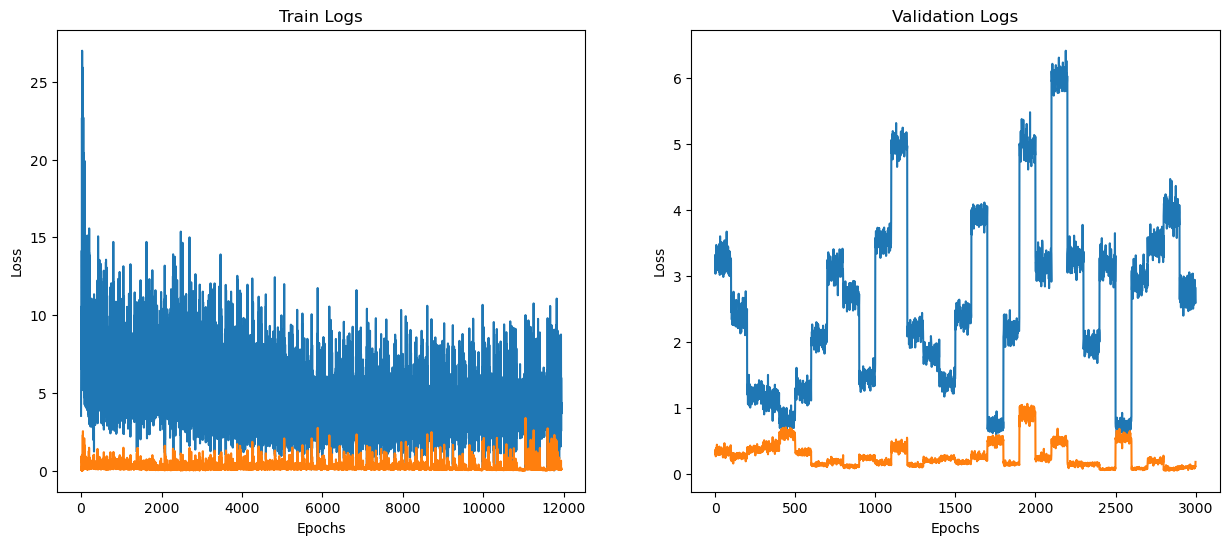

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Train Logs
axes[0].plot(train["G_losses"])
axes[0].plot(train["D_losses"])
axes[0].set_title("Train Logs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plot for Validation Logs
axes[1].plot(val["G_losses"])
axes[1].plot(val["D_losses"])
axes[1].set_title("Validation Logs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

plt.show()

<h1>| Test the Generator</h1>

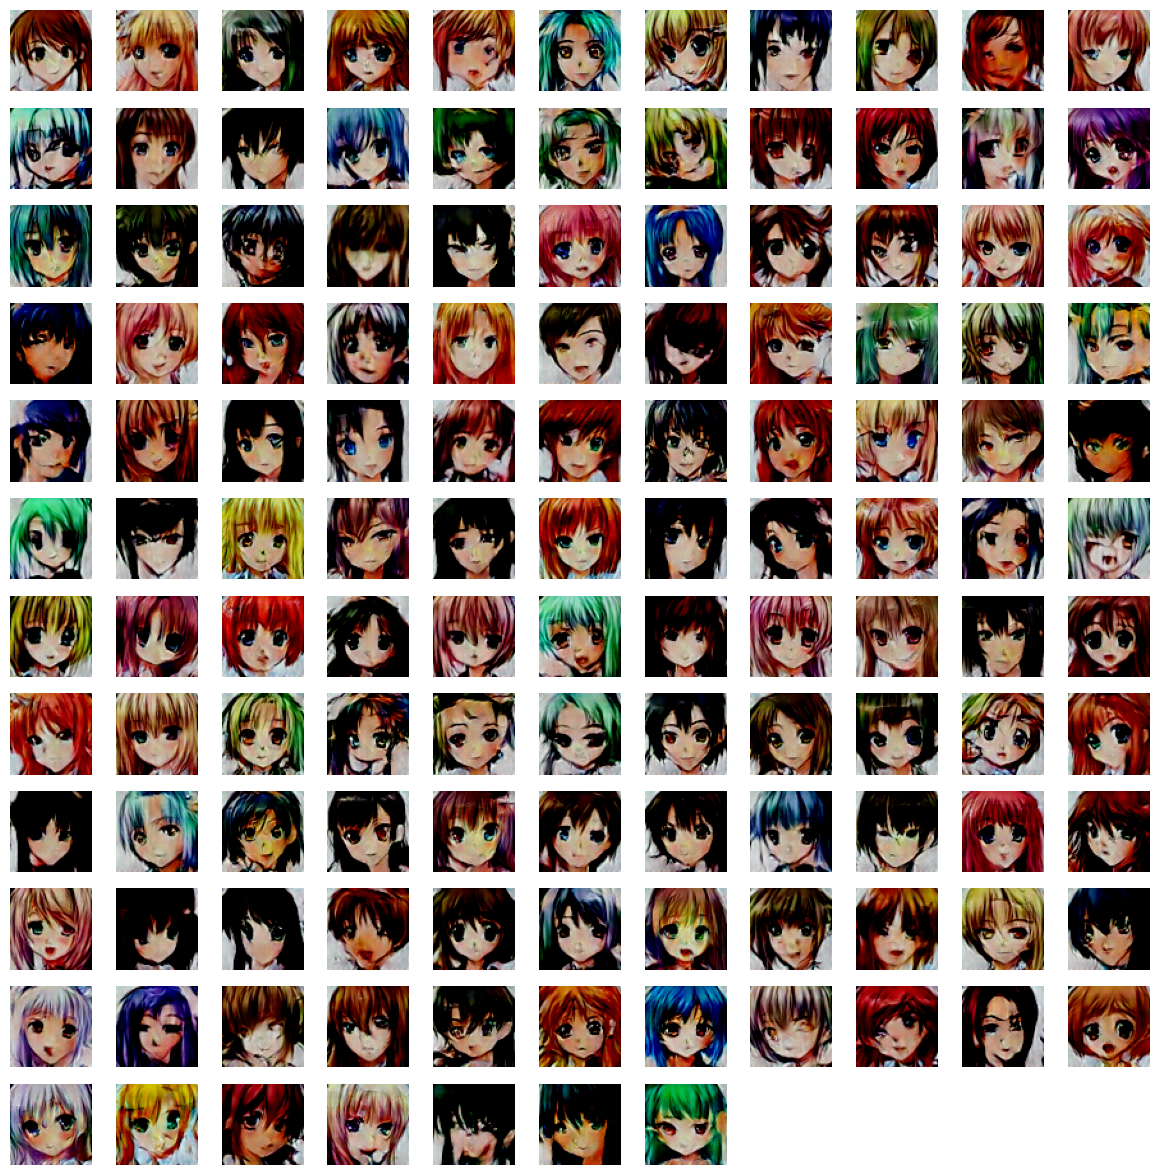

In [10]:
def generated_image_plot(fake_data, title="Generated Images Grid"):
    batch_size, channels, height, width = fake_data.shape

    num_rows = int(np.ceil(np.sqrt(batch_size)))
    num_cols = int(np.ceil(batch_size / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(batch_size):
        img = fake_data[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.axis("off")

    for i in range(batch_size, num_rows * num_cols):
        axes.flatten()[i].axis("off")

    plt.subplots_adjust(wspace=0.01)

    plt.show()
    batch_size, channels, height, width = fake_data.shape

fake_data = netG(fixed_noise)
generated_image_plot(fake_data)

<h1>| Conclusion</h1>
<p style="font-size: 17px">The model performs quite well, but can be drastically improvised. The key issue with DCGAN is BCE loss which provides discrete output of 1 and 0 leading to discriminator being trained much better than generator which in turn leads to vanishing gradient</p>